## Import Library dan Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

Melakukan loading dataset

In [ ]:
DATA_PATH = "ml-100k/u.data"

columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_df = pd.read_csv(DATA_PATH, sep='\t', names=columns)

movie_cols = [
    'item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
    'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]
movies_df = pd.read_csv('ml-100k/u.item', sep='|', names=movie_cols, encoding='latin-1')

df = pd.merge(ratings_df, movies_df[['item_id', 'title']], on='item_id')

Mengetahui contoh isi dari dataframe yang sudah digabung

In [ ]:
df

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)
...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)"
99996,716,204,5,879795543,Back to the Future (1985)
99997,276,1090,1,874795795,Sliver (1993)
99998,13,225,2,882399156,101 Dalmatians (1996)


Mengetahui informasi mengenai dataframe seperti jumlah data Non-Null, jumlah kolom, dan tipe data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100000 non-null  int64 
 1   item_id    100000 non-null  int64 
 2   rating     100000 non-null  int64 
 3   timestamp  100000 non-null  int64 
 4   title      100000 non-null  object
dtypes: int64(4), object(1)
memory usage: 3.8+ MB


Mengetahui statistik deskriptif pada dataframe

In [ ]:
df.describe(include='all')

,user_id,item_id,rating,timestamp,title
count,100000.00000,100000.000000,100000.000000,1.000000e+05,100000
unique,NaN,NaN,NaN,NaN,1664
top,NaN,NaN,NaN,NaN,Star Wars (1977)
freq,NaN,NaN,NaN,NaN,583
mean,462.48475,425.530130,3.529860,8.835289e+08,NaN
std,266.61442,330.798356,1.125674,5.343856e+06,NaN
min,1.00000,1.000000,1.000000,8.747247e+08,NaN
25%,254.00000,175.000000,3.000000,8.794487e+08,NaN
50%,447.00000,322.000000,4.000000,8.828269e+08,NaN
75%,682.00000,631.000000,4.000000,8.882600e+08,NaN


Mengetahui jumlah data yang memiliki missing value

In [ ]:
missing_value = df.isnull().sum()
print(f"Jumlah missing value: {missing_value}")

Jumlah missing value: user_id      0
item_id      0
rating       0
timestamp    0
title        0
dtype: int64


Mengetahui jumlah data yang duplikat

In [ ]:
duplicate = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicate}")

Jumlah data duplikat: 0


Mengetahui berapa baris dan kolom pada data

In [ ]:
df.shape

(100000, 5)

## Data Understanding

Visualisasi distribusi rating, disini terlihat bahwa pengguna cenderung memberikan rating yang baik, yaitu antara 3 dan 4

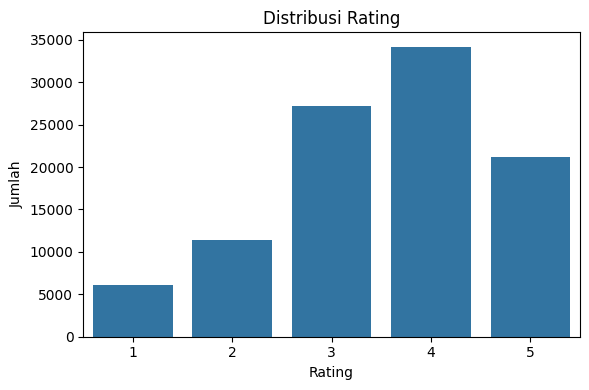

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

Visualisasi Top 10 Film Rating Tertinggi, disini terlihat 10 film klasik yang memang sudah terkenal luas oleh pengguna

<ipython-input-10-0eb0758fd5cc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movie_counts.values, y=movie_counts.index, palette='YlOrBr')


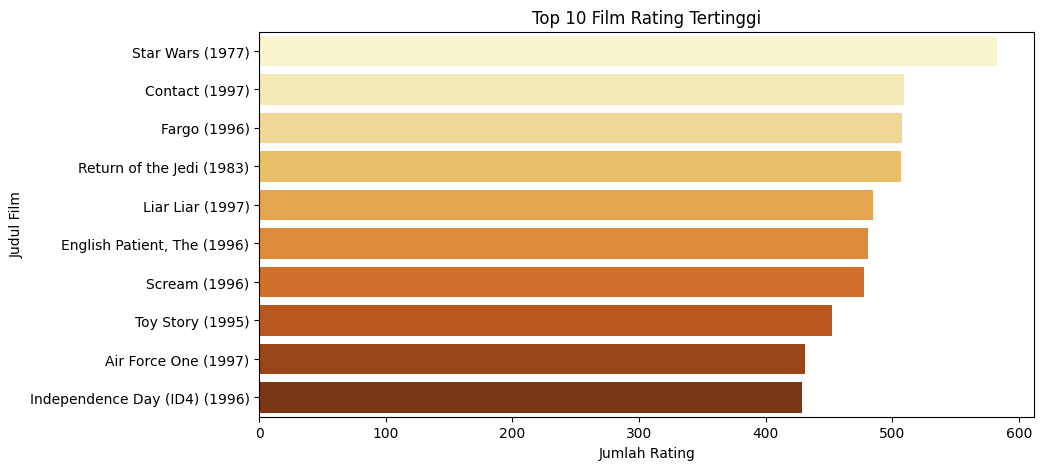

In [ ]:
movie_counts = df['title'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=movie_counts.values, y=movie_counts.index, palette='YlOrBr')
plt.title('Top 10 Film Rating Tertinggi')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Film')
plt.show()

## Data Preprocessing

Membuat matriks user-item

In [ ]:
user_movie_matrix = df.pivot_table(index='user_id', columns='title', values='rating')

Mengisi missing value dengan nilai 0

In [ ]:
user_movie_matrix_filled = user_movie_matrix.fillna(0)

Menghitung cosine similarity antar user

In [ ]:
user_similarity = cosine_similarity(user_movie_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

## Modelling

Fungsi prediksi rekomendasi film

In [ ]:
def recommend_movies(user_id, num_recommendations=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:11]

    weighted_ratings = pd.Series(dtype='float64')

    for sim_user_id, similarity_score in similar_users.items():
        sim_user_ratings = user_movie_matrix.loc[sim_user_id]
        sim_user_ratings = sim_user_ratings[sim_user_ratings > 0]
        weighted_ratings = weighted_ratings.add(sim_user_ratings * similarity_score, fill_value=0)

    user_rated = user_movie_matrix.loc[user_id]
    recommendations = weighted_ratings[~user_rated.notna()].sort_values(ascending=False).head(num_recommendations)

    return recommendations

Contoh prediksi rekomendasi film untuk user_id=40

In [ ]:
recommendations = recommend_movies(user_id=40, num_recommendations=10)
print(recommendations)

title
Apt Pupil (1998)                   15.408980
Titanic (1997)                     14.580566
Apostle, The (1997)                12.512371
In & Out (1997)                    12.356969
Devil's Advocate, The (1997)       11.231197
Seven Years in Tibet (1997)        10.675532
Everyone Says I Love You (1996)    10.651145
Scream (1996)                      10.529645
Cop Land (1997)                     9.948980
In the Company of Men (1997)        8.710036
dtype: float64


Fungsi prediksi rating pada sebuah film

In [ ]:
def predict_rating(user_id, item_title):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:11]
    numerator = 0.0
    denominator = 0.0

    user_mean = user_movie_matrix.loc[user_id].mean()

    for sim_user_id, similarity in similar_users.items():
        rating = user_movie_matrix.loc[sim_user_id, item_title]
        sim_user_mean = user_movie_matrix.loc[sim_user_id].mean()
        if not np.isnan(rating):
            numerator += similarity * (rating - sim_user_mean)
            denominator += abs(similarity)

    if denominator == 0:
        return np.nan
    else:
        return user_mean + (numerator / denominator)

Contoh prediksi rating oleh user_id=40

In [ ]:
predicted_rating = predict_rating(user_id=40, item_title='Titanic (1997)')
print(predicted_rating)

3.614123152617995


## Evaluasi Model

Evaluasi pada 1000 sampel rating

In [ ]:
sample_df = df.sample(1000, random_state=42)
y_true = []
y_pred = []

for _, row in sample_df.iterrows():
    true_rating = row['rating']
    predicted_rating = predict_rating(row['user_id'], row['title'])

    if not np.isnan(predicted_rating):
        y_true.append(true_rating)
        y_pred.append(predicted_rating)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 0.9121
Root Mean Squared Error: 0.9551


## Prediction

Prediksi rekomendasi film untuk user

In [ ]:
user_id = 51
num_recommendations = 10

recommendations = recommend_movies(user_id, num_recommendations)
print(f"Rekomendasi film untuk user {user_id}:")
print(recommendations)

Rekomendasi film untuk user 51:
title
Raiders of the Lost Ark (1981)            14.144349
Terminator 2: Judgment Day (1991)         11.307355
Monty Python and the Holy Grail (1974)    10.940803
Toy Story (1995)                          10.638266
Aliens (1986)                              9.740786
Back to the Future (1985)                  9.677367
Casablanca (1942)                          9.065003
Braveheart (1995)                          8.729574
Schindler's List (1993)                    8.692218
Alien (1979)                               8.470288
dtype: float64


Prediksi rating user terhadap suatu film

In [ ]:
user_id = 51
movie_title = 'Star Wars (1977)'

predicted = predict_rating(user_id, movie_title)
if np.isnan(predicted):
    print(f"Tidak cukup data untuk memprediksi rating user {user_id} terhadap '{movie_title}'.")
else:
    print(f"Prediksi rating user {user_id} untuk film '{movie_title}': {predicted:.2f}")

Prediksi rating user 51 untuk film 'Star Wars (1977)': 4.93
